In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from scipy.ndimage.filters import gaussian_filter1d as gaussian
from glob import glob
from scipy.signal import savgol_filter, medfilt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

In [2]:
# 1. load data into pandas data frame

# 2. convert data from I(t) to c_i(t) via equation for G quadruplex binding
    # - find t0
    # - 
# 3. calculate dc_i/dt for each GUV

# 4. calculate background intensity and convert this to c_0(t) via g quadruplex binding model

# 5. plot dc_/dt/A_GUV vs c_0-c_i (expect to see a positive linear relationship)


# as data includes actual G4 background for GUV permeability and later Gramicidin A experiments, start with these experiments


In [3]:
App = 3.16 #um^2
Amin= 75*App*1e-12 #m^2


# G quadruplex model binding



def exp_I(t,k,c):
    
    k_b = 8.8
    A = 1
#     c = 0.98
#     c = 0.46
    return c+(1-c)/(A*k_b*(1-np.exp(-k*t))**2+1)


def inv(I, k = 8.8,A = 0.5):
    
    if I > 1:
        return 0
    
    elif I < A:
        return 1
        
    else:
        return np.sqrt((1/k)*((1-A)/(I-A)-1))

#smoothing configs

sigma = 30




# Calibration model fit


## **If you have already fitted a calibration function and saved the parameters skip this section**

## Discussion of binding model deficiencies

1. **Binding model**

By considering the binding reaction G4 + nK <=> complex we can develop a model to fit the calibration experiment for the g quadruplex sensor.

It was found that in an excess of potassium the 'completely folded' g quadruplex goes to 0.5 of its free intensity. I assume then that in the intermediate concentrations of potassium, there is a mixture of unfolded and folded g quadruplex. 

Therefore $I = I_0[G4]_{free} + 0.5I_0[G4]_{folded}$,

by assuming on the addition of potassium the system reaches equilibrium much faster than the timescales of the transport, then we gain  $\frac{I}{I_0} = 0.5(\frac{1}{1+K_b[K]^2} +1)$

$K_b$ is found by fitting this function to the calibration.

2. **Problems**

As this function plateaus at 0.5, defining a sensible inverse that can practicably applied to a noisy intensity measurement (to measure [K]  is difficult. As noisy variations near $\frac{I}{I_0}$ cause wild swings in the concentration.

3. **Solution**

Therefore we surpress these swings by defining an approximate inverse that does not diverge at the edges.

We do this by creating an effective intensity of the folded g quadruplex that is artificially lower than the believe value. Therefore our calibration model becomes:

$I = I_0[G4]_{free} + c_{eff}I_0[G4]_{folded}$, where $c_{eff} < 0.5$.
    
$\frac{I}{I_0} = c_{eff} + \frac{1-c_{eff}}{K_b[K]^2 +1}$

**This doesn't really work as we still have a blowing up value, need to define a nicer function**

Define a polynomial approximation that is similar

In [4]:
# finding a suitable calibration

calib_data = pd.read_csv('../20210323_KCLFAMG4Q0to20mMCalib/RelIntensG41Concentration.csv')

In [9]:
%matplotlib qt
I= np.linspace(1,0.2,100)

fig, ax = plt.subplots(1,1)

ax.scatter(calib_data['Rel. Intes'],calib_data['K conc [mM]'],marker = '+',s = 5)

legend = []

# fit a polynomial


fit = np.polyfit(-np.log(calib_data['Rel. Intes'].iloc[:-1]),calib_data['K conc [mM]'].iloc[:-1],3)

def fit_func(I,fit):
    
    c = np.zeros_like(I)
    
    for i in range(1,len(fit)+1):

        c += fit[i-1]*(-np.log(I))**(len(fit)-i)
        print(len(fit)-i)
    return c



ax.plot(I,fit_func(I,fit))

legend.append('Calibration')

def model_fit(cK,kb,c):
    return c + (1-c)/(kb*cK**2+1)

params = curve_fit(model_fit,calib_data['K conc [mM]'],calib_data['Rel. Intes'], p0 = [8.8,0.45])

cK_bar = np.linspace(0,2)
I_bar = model_fit(cK_bar,params[0][0],params[0][1])

ax.set_xlim([0.35,1.05])
ax.plot(I_bar,cK_bar,label = 'Model')
legend.append('Model')

l  = plt.errorbar(calib_data['Rel. Intes'],calib_data['K conc [mM]'],rel_errorK*calib_data['K conc [mM]'],drelI,c = 'k')

ax.set_xticks([0.4,0.6,0.8,1])
ax.set_xticklabels([0.4,0.6,0.8,1],fontsize  = 15)

ax.set_yticks([0,1,2])
ax.set_yticklabels([0,1,2],fontsize = 15)
ax.set_ylim([-0.1,2.1])
plt.tick_params(direction = 'in',top = True,bottom = True,right = True, left = True,length = 5)
ax.set_xlabel('Rel Intensity [a.u]',fontsize = 18)
ax.set_ylabel('[K]/[mM]',fontsize = 18)
l[0].remove()
plt.legend(legend)



3
2
1
0


In [30]:
help(l.remove)

Help on method remove in module matplotlib.container:

remove() method of matplotlib.container.ErrorbarContainer instance



# Errors in calibration

**Errors are mainly due to the focal plane measured**


In [6]:
raw_data = pd.read_csv('../20210323_KCLFAMG4Q0to20mMCalib/1uM/Intensities0-2mM.csv')

In [7]:
n = 512**2

print(raw_data['StdDev']/np.sqrt(n))

dI = raw_data['StdDev']/np.sqrt(n)
drelI = dI/raw_data['Mean']

drelI = drelI*10

0    2.244234
1    2.140793
2    1.921438
3    1.709535
4    1.638162
5    1.617246
Name: StdDev, dtype: float64


# Potassium concentration errors

In [8]:
rel_errorK = 0.02



# Load calibration function parameters and define function



In [4]:
fitsdf = pd.read_csv('../Calibrations/Calibration_approx_fit_params.csv')

fit = fitsdf['Fitting Params']

def fit_func(I,fit):
    
    c = np.zeros_like(I)
    
    for i in range(1,len(fit)+1):

        c += fit[i-1]*(-np.log(I))**(len(fit)-i)
        print(len(fit)-i)
    return c


# Single GUV modelling

In [19]:
t0 = 65
t1 = -1
dt = 15/60

In [20]:
# load 260pM Gramicidin A experiment

dfI = pd.read_csv('../KineticsofLeakageGramicidin/collatedIabs3nM.csv')
dfA = pd.read_csv('../KineticsofLeakageGramicidin/collatedIabs3nM.csv')

In [21]:
dfI = dfI.iloc[:,1:]
dfA = dfA.iloc[:,1:]

In [22]:
dfA = dfA.fillna(0)
dfI = dfI.fillna(0)

# Remove small detected objects, most likely not GUVs

**check that the size is appropriate for the experiment**

In [23]:
# remove traces for GUVs below a certain area

for col in dfI.columns:
    
    if col in dfA.columns:
        area = 1e-12*App*np.mean(dfA[col].iloc[:30])
        
        if area < Amin:
            dfI.pop(col)
            dfA.pop(col)

# Remove intensity curves with sudden drops
## These are likely from GUVs suddenly escaping the trap

In [24]:

def remove_burst_events(data,threshold = 0.45):
    
    for column in data.columns:
        
        if len(data[column][data[column] < threshold]) >=1:
            data.pop(column)
            

In [25]:
%matplotlib qt
fig, ax = plt.subplots(1,1)

for col in dfI.columns:
    ax.plot(dfI[col])

In [26]:
# normalise intensities

for col in dfI.columns:
    dfI[col] = dfI[col]/np.mean(dfI[col][:30])
remove_burst_events(dfI)

# Smooth data

## Smoothing strategy

1. In experiments where there was relatively fast decay in intensity initially, but slows down (as exponential decays do..), yet there is still a lot of noise, it may be necessary to smooth different regions with different 'cutoff's.
When the intensity has dropped, the signal to noise drops. What's more during the slower period of intensity decay, there is increasing likelihood that some long timescale event will have happened to distort the data. This long timescale noise may be of a similar timescale to the 'signal' in the early period of rapid decay. 

2. The **solution** chosen here, is to have the user select a timepoint to bisect the time traces. The early period up until that timepoint is smoothed with the 1st user input smoothing parameter (usually between 11-21). Then the later period of slow decay is smoother with much larger smoothing settings (50-80). In order to ensure a smooth 'stitching' of these differently smoothed traces, we concatenate and repeat the smoothing with the smallest of the two specified smoothing parameters.

In [27]:
def smooth_decay(I,t0,t1=-1,smoothing_0 = 19,smoothing_1 = 81):
    
    
    if smoothing_0 > t1-t0 and t1 != -1:
        raise ValueError('Smoothing parameter cannot be greater than input data')
    
    smoothed_decay_0 = I.iloc[t0:t1]
    
    smoothed_decay_0 = savgol_filter(smoothed_decay_0,smoothing_0,1)
    
    if t1 != -1:
        
        smoothed_decay_1 = I.iloc[t1:]
        smoothed_decay_1  = savgol_filter(smoothed_decay_1,smoothing_1,1)
        
        smoothed_decay = np.concatenate((smoothed_decay_0,smoothed_decay_1))
    else:
        smoothed_decay = smoothed_decay_0
                               
    final_smoothed_decay = savgol_filter(smoothed_decay,smoothing_0,1)
    return final_smoothed_decay
                                   

In [28]:
#Check smoothing still fits data
#
num = 8
fig,axs = plt.subplots(1,num)

for i,col in enumerate(dfI.columns[np.random.randint(0,len(dfI.columns),num)]):
    
    axs[i].plot(dfI[col].iloc[t0:])
    axs[i].plot(smooth_decay(dfI[col],t0,t1 = 150,smoothing_0=19,smoothing_1=101))
    

# Use calibration inverse to convert I to [K]

In [29]:
dfC_dict = {}

# can't exploit numpy broadcasting

for col in dfI.columns:
    
    smoothed_decay = smooth_decay(dfI[col],t0,t1)
#     print(smoothed_decay)
#     normalised_sd = smoothed_decay/np.mean(smoothed_decay[:30])
    
    cs = []
    for I in smoothed_decay:
#         print(I)
        cs.append(fit_func(I,fit))
    
    
    dfC_dict[col] = cs
    
dfC = pd.DataFrame(dfC_dict)

3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


In [18]:
%matplotlib qt

fig, axs = plt.subplots(1,3)

t = dt*np.arange(0,len(dfC))
for col in dfC.columns:
    
    
    axs[0].plot(t,dfC[col])
#     axs[1].plot(t,medfilt(dfI[col].iloc[t0:t1],31))
    axs[2].plot(t,dfI[col].iloc[t0:t1])

    for ax in axs:
        ax.set_ylim([0,1])



In [13]:
# find representative background concentration variation

# tifs = glob('/media/marcus/9C33-6BBD/20210920_GramA_260pM07_3nM815_1mMKCl_1/260pM/*.tif')

# bgs = []

# fig, ax = plt.subplots(1,1)

# for tif in tifs:
    
#     vid = tf.TiffFile(tif)
    
#     frames = vid.asarray()
    
#     bg = np.median(frames,axis  =(1,2))
#     bg = np.array(bg)/np.max(bg)
#     bgs.append(bg)
    
    
#     ax.plot(bg)

# This confirms that the normalised background is the same for each chamber. Suggesting potassium concs are identical between chambers



/home/marcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.
/home/marcus/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/marcus/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


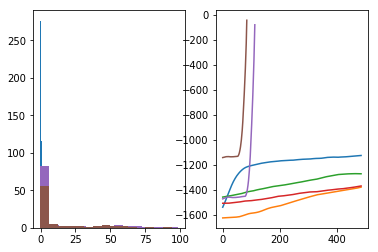

In [13]:
# filter concentration data by gradient
# if 

fig, axs = plt.subplots(1,2)

for col in dfC.columns:
    
    grad = np.gradient(dfC[col])
    
    if len(grad[grad <= -0.0009])/len(grad) > 0.05:
        dfC.pop(col)
        continue
    axs[0].hist(grad,15)
    axs[1].plot(dfC[col])

In [58]:
tifs = glob('/media/marcus/9C33-6BBD/20210427_OmpF_PCPG_KCL_Flush_2-20210427T184510Z-002/20210427_OmpF_PCPG_KCL_Flush_2/*.tif')
tif = tifs[-1]

vid = tf.TiffFile(tif)

frames = vid.asarray()
bg = np.median(frames,axis = (1,2))

bg = np.array(bg)-np.mean(bg[:30])
bg = bg/np.max(bg)

smoothed_bg = medfilt(bg,11)

OME series: not an ome-tiff master file


In [131]:
# c_bg = []
# for x in bg[360+t0:]:
#     c_bg.append(inv(x))

In [132]:
# fig, axs = plt.subplots(1,2)


# smoothed_background = gaussian(c_bg,sigma)
# axs[0].plot(smoothed_background)
# axs[1].plot(bg[360+t0:])

In [80]:
# drift in the background intensity over time, once the potassium has arrived, is causing a drifting predicted potassium concentration
# this is unlikely to be the case in reality.
# Therefore the best thing may be to just assume that after an initial 80 frame boundary region (20 mins) for this exp
# the potassium concentration externally reaches 1mM.


In [30]:
# calculating c_ext - c_i

dfdeltaC_dict = {}

for col in dfC:
    
    dfdeltaC_dict[col] = 1-dfC[col]
    
dfdeltaC = pd.DataFrame(dfdeltaC_dict)

In [35]:
fig, axC = plt.subplots(1,1)

delete_cols = []

for col in dfdeltaC.columns:
    graddeltaC = np.gradient(dfdeltaC[col])
    
    
    if len(graddeltaC[graddeltaC > 0]) > 100:
        delete_cols.append(col)
        continue
        
    axC.plot(dfdeltaC[col])

In [36]:
for col in delete_cols:
    dfdeltaC.pop(col)

In [37]:
# now calculate J

# J = (1/A)*dN/dt = R/3* dc_i/dt

dfJ_dict = {}


for col in dfdeltaC:
    
    if col in dfA:
        print(col)
        delta_c = np.gradient(dfC[col],dt)/60 #molm^-3s^-1
        print(dfC[col])
        A = np.mean(dfA[col].iloc[:30])*App*1e-12 #m^2
#         if A < Amin:
#             continue
        R = np.sqrt(A/np.pi) #m
        
        dfJ_dict[col] = R/3*delta_c #molm^-2s^-1
        

dfJ = pd.DataFrame(dfJ_dict)




03018
0      0.08778973433023228
1      0.09547561961751737
2      0.10305394973051782
3      0.11052590156891119
4      0.11789272396999326
5       0.1251557406374414
6      0.13231635319329416
7      0.13937604435885417
8       0.1463363812705107
9      0.15319901893679277
10     0.16016246782675359
11     0.16706769170816757
12     0.17389641933401206
13     0.18055396053693512
14     0.18714306503375971
15     0.19364826750458394
16      0.2000965077375929
17      0.2065348753928754
18     0.21285410312049927
19      0.2191090303107946
20     0.22532876818552885
21     0.23144251860042686
22     0.23745702438648109
23     0.24337862301440874
24      0.2492657243704669
25      0.2550265038135329
26     0.26062404750658147
27      0.2659492513087917
28      0.2711009489920076
29      0.2759377123646793
              ...         
454       0.38968784610864
455     0.3900991598727979
456      0.390311402331965
457     0.3906229766695753
458     0.3909191724543881
459    0.3911941785266

In [22]:
fig, axs = plt.subplots(1,3)
legend = []

for col in dfJ.columns:

    legend.append(col)
#     print(dfdeltaC)

    axs[0].scatter(dfdeltaC[col],dfJ[col]*1e10, marker = '+', s = 10)
    print(dfJ[col])

    axs[1].plot(dt*np.arange(0,len(dfC[col])),dfC[col])

    
#     gradients = []
#     win = 10
#     for i in range(dfJ[col].shape[0]-(win-1)):
        
#         gradient = np.mean(np.gradient(dfJ[col].iloc[i:i+win]))
#         gradients.append(gradient)
        
    
    axs[2].plot(np.gradient(dfJ[col],dfdeltaC[col]))
axs[0].tick_params(direction = 'in',left = True,right = True,bottom = True,top = True,length = 6)
axs[1].tick_params(direction = 'in',left = True,right = True,bottom = True,top = True,length = 6)
axs[0].set_xlabel('[K_ext]-[K_int] [mM]',fontsize = 18)

axs[0].set_ylabel('J [molm^-2s^-1]',fontsize = 18)

axs[1].set_ylabel('[K_int] [mM]',fontsize = 18)


axs[1].set_xlabel(' T [mins]',fontsize = 18)


#xticks

axs[0].set_xticks([0,0.5,1])
axs[0].set_xticklabels([0,0.5,1],fontsize = 15)
axs[0].set_xlim([0,1.05])

axs[1].set_xticks([0,60,120])
axs[1].set_xticklabels([0,60,120],fontsize = 15)

#yticks

axs[0].set_yticks([0,0.01,0.02])
axs[0].set_yticklabels([0,0.01,0.02],fontsize = 15)

axs[0].set_ylim([-0.0005,0.0105])
axs[1].set_yticks([0, 0.5,1])
axs[1].set_yticklabels([0,0.5,1],fontsize = 15)


axs[0].set_ylim([-0.0005,0.0205])
axs[1].set_ylim([-0.05,1.05])


plt.legend(legend)
# plt.rcParams['text.usetex'] = True

# def myticks(x,pos):

#     if x == 0: return "$0$"

#     exponent = int(np.log1

#     coeff = x/10**exponent

#     return r"${:2.0f} \times 10^{{ {:2d} }}$".format(coeff,exponent)

# axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(myticks))

0     -6.194001e-10
1     -6.196731e-10
2     -6.202192e-10
3     -6.207656e-10
4     -6.213121e-10
5     -6.218588e-10
6     -6.224057e-10
7     -6.229527e-10
8     -6.234999e-10
9     -6.671621e-10
10    -7.266336e-10
11    -6.684567e-10
12    -5.974885e-10
13    -5.445802e-10
14    -4.571183e-10
15    -3.361335e-10
16    -2.130722e-10
17    -1.371179e-10
18    -9.652303e-12
19     7.735025e-11
20    -3.529759e-11
21    -4.534398e-11
22     1.459296e-10
23     1.243547e-10
24    -6.772734e-12
25    -5.606538e-12
26     1.702743e-11
27     4.556855e-11
28     1.727364e-10
29     3.463584e-10
           ...     
454   -4.296798e-10
455   -4.357307e-10
456   -4.615231e-10
457   -4.928011e-10
458   -4.517343e-10
459   -4.297786e-10
460   -5.439470e-10
461   -6.753304e-10
462   -7.292492e-10
463   -7.744054e-10
464   -7.691267e-10
465   -7.456559e-10
466   -6.900822e-10
467   -5.941854e-10
468   -5.119193e-10
469   -3.916256e-10
470   -2.953466e-10
471   -2.843838e-10
472   -3.554253e-10


0      2.135854e-09
1      2.132620e-09
2      2.126156e-09
3      2.119699e-09
4      2.113249e-09
5      2.106806e-09
6      2.100371e-09
7      2.093944e-09
8      2.087525e-09
9      2.080050e-09
10     1.972977e-09
11     1.727344e-09
12     1.433686e-09
13     1.229859e-09
14     1.094768e-09
15     1.001594e-09
16     1.054070e-09
17     9.440535e-10
18     7.350522e-10
19     6.913714e-10
20     9.722272e-10
21     1.384044e-09
22     1.446013e-09
23     1.268136e-09
24     1.067645e-09
25     8.347759e-10
26     7.778883e-10
27     9.715160e-10
28     8.317685e-10
29     6.470244e-10
           ...     
454    6.439563e-10
455    1.109224e-09
456    5.300466e-10
457    6.562781e-11
458    3.145492e-10
459    1.474810e-10
460   -1.784352e-10
461   -7.616298e-12
462   -1.513713e-10
463   -3.753445e-10
464   -5.865982e-10
465   -1.120090e-09
466   -1.392736e-09
467   -1.623077e-09
468   -1.940012e-09
469   -2.686812e-09
470   -3.634556e-09
471   -4.256831e-09
472   -4.701671e-09


0     -5.621560e-10
1     -5.625981e-10
2     -5.634845e-10
3     -5.643749e-10
4     -5.652693e-10
5     -5.661677e-10
6     -5.670700e-10
7     -5.679763e-10
8     -5.688864e-10
9     -5.922982e-10
10    -5.153358e-10
11    -6.054889e-10
12    -1.047647e-09
13    -1.171009e-09
14    -9.417359e-10
15    -8.089172e-10
16    -3.715809e-10
17     1.170049e-10
18     2.591566e-10
19     6.238980e-10
20     9.957864e-10
21     4.568681e-10
22    -7.172773e-10
23    -9.998508e-10
24    -1.015442e-09
25    -7.139145e-10
26    -4.173279e-10
27    -7.083322e-10
28    -7.703191e-10
29    -5.909974e-10
           ...     
454   -2.095296e-09
455   -2.116750e-09
456   -1.853461e-09
457   -1.159250e-09
458   -4.298391e-10
459   -2.426728e-11
460    6.724039e-11
461   -2.537041e-11
462   -8.557626e-11
463    2.550303e-10
464    5.957349e-10
465    6.266387e-10
466    8.080905e-10
467    9.728137e-10
468    1.024719e-09
469    1.135803e-09
470    1.279594e-09
471    1.345264e-09
472    1.416933e-09


0     -7.165409e-10
1     -7.169916e-10
2     -7.178932e-10
3     -7.187953e-10
4     -7.196978e-10
5     -7.206007e-10
6     -7.215040e-10
7     -7.224077e-10
8     -7.233118e-10
9     -6.539599e-10
10    -5.465022e-10
11    -5.125868e-10
12    -4.320801e-10
13    -3.128127e-10
14    -2.304033e-10
15    -1.605721e-10
16    -8.641943e-11
17     3.034677e-11
18     1.111445e-10
19     3.341720e-11
20    -2.005568e-11
21    -1.168376e-11
22     4.728379e-12
23     7.305032e-11
24     9.817535e-11
25     1.699859e-10
26     1.152705e-10
27     4.596503e-11
28     3.683206e-11
29    -4.112212e-11
           ...     
454    3.715370e-10
455    3.393207e-10
456    3.865978e-10
457    4.677523e-10
458    5.054976e-10
459    5.348866e-10
460    5.726001e-10
461    5.377719e-10
462    4.217207e-10
463    2.621948e-10
464    2.077222e-10
465    1.627571e-10
466    6.304373e-11
467   -4.443458e-12
468   -9.987245e-11
469   -1.246284e-10
470   -1.190746e-10
471   -2.819819e-10
472   -5.014361e-10


/home/marcus/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1069: RuntimeWarning: divide by zero encountered in double_scalars
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/marcus/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1070: RuntimeWarning: divide by zero encountered in double_scalars
  b = (dx2 - dx1) / (dx1 * dx2)
/home/marcus/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1071: RuntimeWarning: divide by zero encountered in double_scalars
  c = dx1 / (dx2 * (dx1 + dx2))
/home/marcus/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1077: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


0      1.807901e-09
1      1.805777e-09
2      1.801532e-09
3      1.797290e-09
4      1.793050e-09
5      1.788813e-09
6      1.784580e-09
7      1.780348e-09
8      1.776120e-09
9      1.636491e-09
10     1.455258e-09
11     1.306976e-09
12     1.150892e-09
13     9.706117e-10
14     8.211938e-10
15     7.006940e-10
16     4.576835e-10
17     1.530325e-10
18    -2.092485e-10
19    -4.330212e-10
20    -4.453269e-10
21    -4.848764e-10
22    -4.729716e-10
23    -4.012397e-10
24    -4.228781e-10
25    -3.930532e-10
26    -2.836136e-10
27    -2.612737e-10
28    -1.159799e-10
29    -1.670799e-11
           ...     
454   -4.506807e-10
455   -4.365878e-10
456   -4.247339e-10
457   -3.152024e-10
458   -2.314584e-10
459   -2.754228e-10
460   -2.250010e-10
461   -1.945849e-10
462   -2.378897e-10
463   -2.422949e-10
464   -2.107050e-10
465   -1.958249e-10
466   -1.563792e-10
467   -1.015433e-10
468   -8.475703e-11
469   -3.686274e-11
470   -8.955500e-12
471   -8.293640e-13
472   -1.666343e-12


0     -4.406384e-12
1     -4.406397e-12
2     -4.406423e-12
3     -4.406450e-12
4     -4.406476e-12
5     -4.406503e-12
6     -4.406529e-12
7     -4.406556e-12
8     -4.406582e-12
9     -1.424082e-11
10     5.021397e-11
11     1.156304e-10
12     1.147637e-10
13     1.242980e-10
14     1.261782e-10
15     1.536981e-10
16     2.191816e-10
17     2.733397e-10
18     3.300352e-10
19     4.039136e-10
20     3.928829e-10
21     4.451131e-10
22     5.309813e-10
23     4.916001e-10
24     5.346257e-10
25     4.849880e-10
26     5.350828e-10
27     7.370353e-10
28     6.933339e-10
29     4.769434e-10
           ...     
454    4.622065e-11
455    8.973049e-11
456    1.023215e-10
457    9.369939e-11
458    2.909464e-11
459   -1.775125e-11
460   -3.074282e-11
461   -2.082168e-10
462   -2.288238e-10
463   -1.791673e-10
464   -1.587957e-10
465   -3.608378e-12
466    1.508326e-10
467    3.344849e-10
468    5.244407e-10
469    7.082917e-10
470    7.745498e-10
471    8.560603e-10
472    9.938423e-10


0      1.157890e-09
1      1.156748e-09
2      1.154463e-09
3      1.152180e-09
4      1.149898e-09
5      1.147618e-09
6      1.145339e-09
7      1.143062e-09
8      1.140787e-09
9      1.021672e-09
10     9.030405e-10
11     7.937238e-10
12     6.488525e-10
13     4.913499e-10
14     3.367992e-10
15     3.336186e-10
16     2.900799e-10
17     1.451186e-10
18     5.498803e-11
19     1.421681e-10
20     2.139522e-10
21     2.962353e-10
22     3.897957e-10
23     5.323089e-10
24     6.620700e-10
25     5.083835e-10
26     4.410342e-10
27     5.180540e-10
28     6.156703e-10
29     5.852482e-10
           ...     
454   -5.006452e-10
455   -4.479946e-10
456   -2.816444e-10
457   -2.198542e-10
458   -1.086478e-10
459    7.641321e-11
460    2.265499e-11
461   -5.403438e-11
462    9.336078e-12
463    1.503374e-10
464    3.506457e-10
465    4.645323e-10
466    4.687554e-10
467    5.543166e-10
468    6.667268e-10
469    7.776013e-10
470    9.592203e-10
471    1.036513e-09
472    1.053789e-09


0      7.151836e-10
1      7.149068e-10
2      7.143532e-10
3      7.137997e-10
4      7.132463e-10
5      7.126931e-10
6      7.121400e-10
7      7.115871e-10
8      7.110343e-10
9      6.004363e-10
10     5.484698e-10
11     5.651110e-10
12     5.474216e-10
13     5.057560e-10
14     4.172186e-10
15     4.186064e-10
16     3.941763e-10
17     2.956958e-10
18     2.432819e-10
19     2.065129e-10
20    -4.795612e-12
21    -2.045249e-10
22    -1.940341e-10
23    -8.281076e-11
24    -1.336880e-10
25    -1.058315e-10
26    -3.689302e-11
27    -6.173467e-11
28     1.533503e-11
29    -6.456669e-11
           ...     
454    3.631323e-10
455    1.475660e-10
456    2.042612e-11
457    2.186166e-11
458   -1.296481e-10
459   -9.004566e-11
460    1.129454e-10
461    1.302525e-10
462    7.274646e-11
463    1.170024e-10
464    2.737547e-10
465    2.707602e-10
466    1.875746e-10
467    1.167117e-10
468    1.268681e-10
469    9.311123e-11
470   -1.062928e-10
471   -2.273490e-10
472   -2.595777e-10


0      7.303627e-10
1      7.299898e-10
2      7.292439e-10
3      7.284983e-10
4      7.277529e-10
5      7.270077e-10
6      7.262628e-10
7      7.255181e-10
8      7.247736e-10
9      7.484732e-10
10     8.118433e-10
11     8.041423e-10
12     5.991244e-10
13     5.529451e-10
14     1.017193e-09
15     1.385211e-09
16     1.460734e-09
17     1.532963e-09
18     1.621262e-09
19     1.637177e-09
20     1.774479e-09
21     2.072266e-09
22     2.211145e-09
23     2.237491e-09
24     2.339620e-09
25     2.278655e-09
26     2.129785e-09
27     2.147434e-09
28     2.191951e-09
29     2.178863e-09
           ...     
454    1.762560e-09
455    1.793099e-09
456    1.799602e-09
457    1.528331e-09
458    1.139874e-09
459    1.011519e-09
460    8.878740e-10
461    1.226370e-09
462    1.634069e-09
463    9.864151e-10
464    2.113184e-10
465   -3.363933e-11
466   -4.787951e-10
467   -8.473332e-10
468   -9.969946e-10
469   -1.139061e-09
470   -1.531279e-09
471   -1.930932e-09
472   -2.068459e-09


0      2.431771e-09
1      2.426762e-09
2      2.416750e-09
3      2.406752e-09
4      2.396769e-09
5      2.386801e-09
6      2.376847e-09
7      2.366910e-09
8      2.356988e-09
9      2.207270e-09
10     2.056018e-09
11     1.991777e-09
12     1.960246e-09
13     1.904292e-09
14     1.839525e-09
15     1.807167e-09
16     1.644713e-09
17     1.458863e-09
18     1.229405e-09
19     9.618795e-10
20     9.244871e-10
21     9.659362e-10
22     6.987135e-10
23     4.718401e-10
24     4.018205e-10
25     2.580529e-10
26     2.264384e-11
27    -2.005636e-10
28    -1.896724e-10
29    -2.358182e-10
           ...     
454    3.259926e-10
455    2.485868e-10
456    1.095640e-10
457   -1.701219e-11
458    4.717953e-11
459    1.193841e-10
460    2.495699e-11
461   -6.303014e-11
462    2.524792e-11
463   -4.410897e-11
464   -7.274861e-11
465   -1.730578e-13
466    1.022249e-11
467    1.224462e-12
468   -6.199521e-11
469   -1.481505e-10
470   -2.581731e-10
471   -3.078389e-10
472   -3.908499e-10


0      2.169497e-09
1      2.165881e-09
2      2.158651e-09
3      2.151428e-09
4      2.144212e-09
5      2.137004e-09
6      2.129803e-09
7      2.122609e-09
8      2.115423e-09
9      2.064329e-09
10     1.953024e-09
11     1.828899e-09
12     1.635767e-09
13     1.341222e-09
14     1.086993e-09
15     8.959556e-10
16     7.191735e-10
17     6.098181e-10
18     4.804511e-10
19     3.436708e-10
20     2.462011e-10
21     1.522687e-10
22     7.487284e-11
23     3.764553e-11
24     7.472384e-11
25     8.095350e-11
26     1.904099e-11
27    -5.760895e-11
28    -9.892209e-11
29    -1.494068e-10
           ...     
454    5.801359e-11
455    9.330512e-11
456    1.236401e-10
457    2.402633e-10
458    2.745841e-10
459    1.994445e-10
460    1.442766e-10
461    1.531783e-10
462    1.978095e-10
463    2.023227e-10
464    1.979893e-10
465    8.773307e-11
466   -6.644847e-11
467   -9.210068e-11
468   -1.289553e-10
469   -3.154970e-10
470   -4.569124e-10
471   -5.531908e-10
472   -6.707636e-10


In [38]:
%matplotlib qt
figJ, axJ = plt.subplots(1,1)
figC, axC = plt.subplots(1,1)



def Jfit(deltac,k,c):
    return k*deltac + c

p0 = [1e-14,0]
Pparams = {}
for i,col in enumerate(dfJ.columns):
    

    t = dt*np.arange(0,len(dfC[col]))
    
    J = dfJ[col].iloc[t > 0]
    deltaC = dfdeltaC[col].iloc[t > 0]
    
#     deltaC_bar = np.linspace(dfC[col].min(),1)
    
    params = curve_fit(Jfit,deltaC,J,p0)
    
    J_bar = Jfit(deltaC,*params[0])
    P = params[0][0]
    dP = np.sqrt(params[1][0][0])
    print(dP/P, P)
    

    
    if  P < 0:
        
        continue
        
    Pparams[col] = params
    if len(J.iloc[(deltaC < 0.7).to_numpy()]) < 1:
        continue
    print(col)
   
    # plot fluxes
    axJ.scatter(deltaC,J,alpha = 0.25)
    axJ.plot(deltaC,J_bar)
    
    #plot the Intensity vs time
    
    axC.plot(t,dfI[col].iloc[t0:t1])
 
#Flux plot params


axJ.set_xticks([0,0.5,1])
axJ.set_xlim([-0.05,1.05])
axJ.set_xticklabels([0,0.5,1],fontsize = 15)

axJ.set_xlabel('$[K]_{ext} - [K]_{in}$ [mM]',fontsize = 18)
axJ.set_yticks([0,2.5e-9,5e-9,7.5e-9,1e-8])
axJ.set_yticklabels([0,2.5,5,7.5,10],fontsize = 15)

axJ.set_ylim([-1e-9,1.1e-8])
    
axJ.set_ylabel('J  [$10^{-9}$ mol$m^{-2}s^{-1}$]',fontsize = 18)
axJ.tick_params(direction = 'in',left = True,right = True, top = True, bottom = True,length = 7)

axC.set_xticks([0,20,40])
axC.set_xticklabels([0,20,40],fontsize = 15)
axC.set_xlabel('Time [mins]',fontsize = 18)
axC.set_xlim([-2,45])
axC.set_yticks([0,0.5,1])
axC.set_yticklabels([0,0.5,1],fontsize = 15)
axC.set_ylabel('Rel I',fontsize = 18 )
axC.tick_params(direction = 'in',left = True,right = True, top = True, bottom = True,length = 7)
axC.set_ylim([-0.05,1.05])

# global params

# plt.tick_params(direction = 'in',left = True,right = True, top = True, bottom = True,length = 7)

0.01976240388856101 3.281302236063397e-08
03018
0.017393753300205806 9.202478652093743e-09
03023
0.008642720306329503 1.2025181452389952e-08
03028
0.057107382308058355 5.55339754175102e-09
06020
0.020532598618346467 1.0767050813640098e-08
02040
0.09332197113754664 2.706790682122009e-09
0.131960099952037 2.423148655307007e-09
0.12515663734415702 1.4921086357536028e-09
04034
-0.38005200390989463 -9.928266556141275e-10
0.03335769146997376 3.539786196875367e-09
04048
1.502574566807242 1.9323863020800978e-10
0.1652119244191932 1.0582085549274917e-09
-0.5872765225402147 -1.0196334215306488e-09
0.02662141931485345 8.660880139124017e-09
00005
-0.16986511492201298 -1.4233778341204602e-09
0.01230396588719041 1.943059986310882e-08
00040
0.01094441021638934 1.1699881826367278e-08
01003
0.010176286013342193 1.466739535707483e-08
01037
0.21686584741470594 2.180609772804495e-09
01047
0.03426532378900687 7.84923351838263e-09
05026
-2.077637149372851 -2.121316484550604e-10


(-0.05, 1.05)

# Save permeability values


In [51]:
P_df = {'P ms^-1': [Pparams[key][0][0] for key in Pparams.keys()],
       'dP/P': [np.sqrt(Pparams[key][1][0][0])/Pparams[key][0][0] for key in Pparams.keys()],
       'A':[np.mean(dfA[key].iloc[:30]) for key in Pparams.keys()]}
   
P_identified = {key:[Pparams[key][0][0]] for key in Pparams.keys()}
P_df = pd.DataFrame(P_df)

P_df['P cms^-1'] = P_df['P ms^-1']*100

P_df.to_csv('Permeabilities_GramicidinA_3nM_20210920.csv')

In [53]:
P_identified = pd.DataFrame(P_identified)

# Save Flux vs deltaC data

In [54]:
dfJ.to_csv('Flux_GramA_3nM_20210920.csv')
dfdeltaC.to_csv('deltaC_GramA_3nM_20210920.csv')
P_identified.to_csv('PbyGUVId_GramA_3nM_20210920.csv')

# The relationship between J and delta c

The variation of the flux, J, with $\Delta c$ is linear. However in order to gain a good fit, we have to relax ths condition that the flux is zero when the gradient is 0. 

Near to 1mM internal concentration the calibration underestimates the internal concentration. Therefore it overestimates the concentration gradient at the point of zero flux. This develops an associated error in the y intercept and the permeability.


In [206]:
JoverP = {}

for col in dfJ.columns:
    
    P = Pparams[col][0][0]
    dP = np.sqrt(Pparams[col][1][0][0])
    
    if dP/P > 0.1 or P < 0:
        
        continue
    
    JoverP[col] = dfJ[col]/P
    
dfJoverP = pd.DataFrame(JoverP)


fig, ax = plt.subplots(1,1)

for col in dfJoverP.columns:
    
    ax.scatter(dfdeltaC[col],dfJoverP[col])
    

/home/marcus/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [156]:
axs[2].cla()